تمرین سوم فیزیک اقتصاد

سپهر سلمانی یگانه ۴۰۰۱۰۰۲۶۵

سارا اکبری خرم ۴۰۰۱۰۹۳۰۵

In [173]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import itertools

تابع ساخت اردینال پترن

In [174]:
def op_generator(dim):
    return list(itertools.permutations([i for i in range(dim)]))

تبدیل یک سری زمانی قیمت به سری زمانی از #شماره اردینال پترن

In [175]:
def raw_data_to_ordinal_pattern_data(data):
    op_data = np.zeros(data_len - dimension + 1, dtype=np.int8)
    for i in range(data_len - dimension + 1):
        window = data[i:i + dimension]
        window_sorted = np.sort(window)
        op = tuple(np.where(window_sorted == datum)[0][0] for datum in window)
        for j in range(op_len):
            if op == ordinal_patterns[j]:
                op_data[i] = j
    return op_data

تغییر دیتا با لحاظ کردن تاخیر

In [176]:
def delayed_data(x_raw, y_raw, delay = 1):
    x_new = np.array(x_raw[:-delay])
    y_new = np.array(y_raw[:-delay])
    x_delayed = np.array(x_raw[delay:]) 
    return x_new, y_new, x_delayed

تابع محاسبه احتمال‌های شرطی و پیوسته. بر روی داده‌ها پیمایش می‌کنیم و در نهایت تعداد رخ دادن هر الگو را به تعداد کل تقسیم می‌کنیم

In [177]:
def probabilities(x_, y_, z_):
    n = len(x_)
    jp = np.zeros((op_len, op_len, op_len)) # joint probability P(x,y,z)
    mp_xy = np.zeros((op_len, op_len)) # marginal probability P(x,y)
    mp_xz = np.zeros((op_len, op_len)) # marginal probability P(x,z)
    p_x = np.zeros(op_len) # P(x)
    for i in range(n):
        jp[x_[i]][y_[i]][z_[i]] += 1
        mp_xy[x_[i]][y_[i]] += 1
        mp_xz[x_[i]][z_[i]] += 1
        p_x[x_[i]] += 1
    return jp/n, mp_xy/n, mp_xz/n, p_x/n

تابع ترنسفر انتروپی به فرم معمول

In [178]:
def transfer_entropy1(jp, mp_xy, mp_xz, p_x):
    return H2(mp_xy) + H2(mp_xz) -H1(p_x) - H3(jp)

def H1(prob):
    s = 0
    for x in range(len(prob)):
        if prob[x] != 0: s -= prob[x] * np.log2(prob[x])
    return s

def H2(prob):
    s = 0
    for x in range(len(prob)):
        for y in range(len(prob[x])):
            if prob[x][y] != 0: s -= prob[x][y] * np.log2(prob[x][y])
    return s

def H3(prob):
    s = 0
    for x in range(len(prob)):
        for y in range(len(prob[x])):
            for z in range(len(prob[x][y])):
                if prob[x][y][z] != 0: s -= prob[x][y][z] * np.log2(prob[x][y][z])
    return s

تابع ترنسفر انتروپی به فرم داده شده در کلاس

In [179]:
def transfer_entropy2(jp, mp_xy, mp_xz, p_x):
    te = 0
    for x in range(6):
        for y in range(6):
            for z in range(6):
                if mp_xy[x][y] and mp_xz[x][z] and p_x[x] and jp[x][y][z]:
                    te += jp[x][y][z]*np.log2(jp[x][y][z]*p_x[x]/mp_xy[x][y]/mp_xz[x][z])
    return te

تابع محاسبه جریان خالص انتروپی

In [180]:
def net_flow(T, x, y):
    return (abs(T[x][y]) - abs(T[y][x]))/(abs(T[x][y]) + abs(T[y][x]))

داده‌ها را لود می‌کنیم

In [181]:
data_all = np.loadtxt("Ex3-test.txt", usecols=(1, 2, 3)).transpose()
data_len = len(data_all[0]) # number of datum in each data
time_series_num = len(data_all) # number of time series

اردینال پترن‌ها را آماده می‌کنیم

In [182]:
dimension = 3 # dimension of ordinal pattern
ordinal_patterns = op_generator(dimension)
op_len = len(ordinal_patterns) # number of op
op_data_all = np.array([raw_data_to_ordinal_pattern_data(data) for data in data_all])
op_data_len = len(op_data_all[0])

In [183]:
print("ordinal patterns and their numbers")
for i in range(op_len):
    print(f"# {i}: {ordinal_patterns[i]}")

ordinal patterns and their numbers
# 0: (0, 1, 2)
# 1: (0, 2, 1)
# 2: (1, 0, 2)
# 3: (1, 2, 0)
# 4: (2, 0, 1)
# 5: (2, 1, 0)


ماتریس انتقال انتروپی را با هر دو تابع حساب می‌کنیم

In [184]:
transfer_entropy_matrix1 = np.zeros((time_series_num, time_series_num))
transfer_entropy_matrix2 = np.zeros((time_series_num, time_series_num))
for i in range(time_series_num):
    for j in range(time_series_num):
        x_hat, y_hat, z_hat = delayed_data(op_data_all[i], op_data_all[j])
        joint, marginal_xy, marginal_xz, prob_x = probabilities(x_hat, y_hat, z_hat)
        transfer_entropy_matrix1[i][j] = transfer_entropy1(joint, marginal_xy, marginal_xz, prob_x)
        transfer_entropy_matrix2[i][j] = transfer_entropy2(joint, marginal_xy, marginal_xz, prob_x)

In [185]:
transfer_entropy_matrix1

array([[2.22044605e-16, 4.62837368e-02, 5.97521133e-03],
       [1.69111516e-03, 0.00000000e+00, 1.79140544e-03],
       [1.18256465e-03, 1.44286193e-03, 0.00000000e+00]])

In [186]:
transfer_entropy_matrix2

array([[0.00000000e+00, 4.62837368e-02, 5.97521133e-03],
       [1.69111516e-03, 0.00000000e+00, 1.79140544e-03],
       [1.18256465e-03, 1.44286193e-03, 2.24908371e-18]])

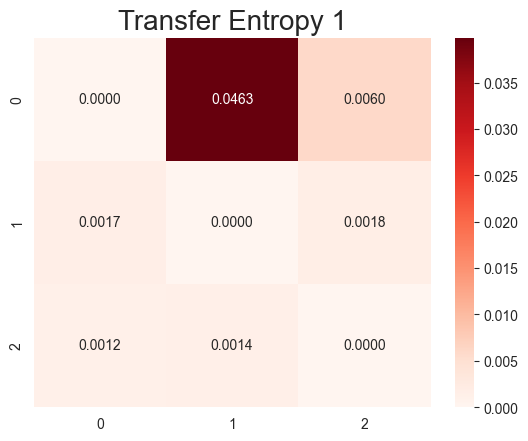

In [187]:
te_heatmap1 = sn.heatmap(transfer_entropy_matrix1, annot=True, fmt=".4f", cmap="Reds", robust=True)
plt.title("Transfer Entropy 1", fontsize = 20)
plt.show()
plt.close()

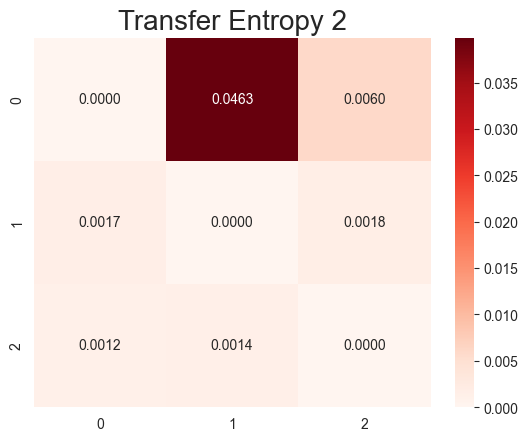

In [188]:
te_heatmap2 = sn.heatmap(transfer_entropy_matrix2, annot=True, fmt=".4f", cmap="Reds", robust=True)
plt.title("Transfer Entropy 2", fontsize = 20)
plt.show()
plt.close()

ماتریس جریان خالص انتروپی را حساب می‌کنیم

In [189]:
net_entropy_flow1 = np.zeros((time_series_num, time_series_num))
net_entropy_flow2 = np.zeros((time_series_num, time_series_num))
for i in range(time_series_num):
    for j in range(time_series_num):
        if i != j:
            net_entropy_flow1[i][j] = net_flow(transfer_entropy_matrix1, i, j)
            net_entropy_flow2[i][j] = net_flow(transfer_entropy_matrix2, i, j)

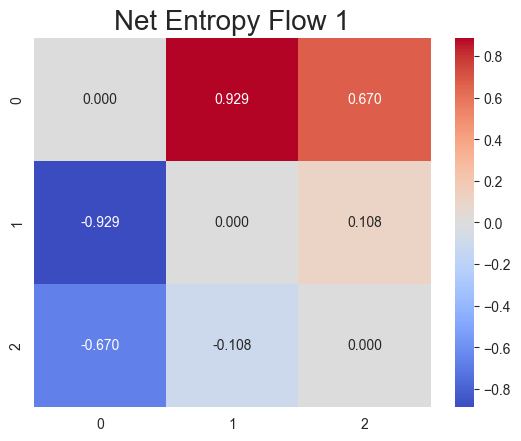

In [190]:
nf_heatmap1 = sn.heatmap(net_entropy_flow1, center=0, annot=True, fmt=".3f", cmap="coolwarm", robust=True)
plt.title("Net Entropy Flow 1", fontsize = 20)
plt.show()
plt.close()

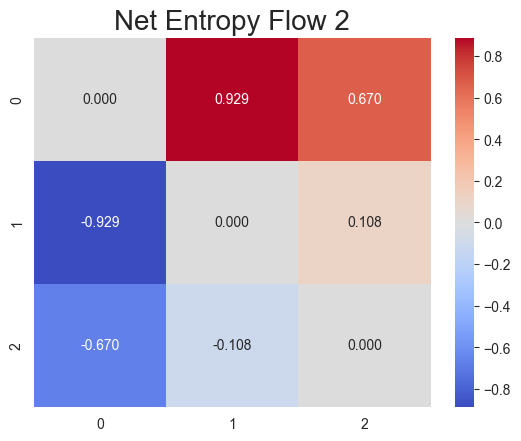

In [191]:
nf_heatmap2 = sn.heatmap(net_entropy_flow2, center=0, annot=True, fmt=".3f", cmap="coolwarm", robust=True)
plt.title("Net Entropy Flow 2", fontsize = 20)
plt.show()
plt.close()